### Install dependencies

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 16.9MB/s 
     |████████████████████████████████| 890kB 47.8MB/s 
     |████████████████████████████████| 2.9MB 46.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a82e5022c849cbdcdb7c497e323df798db837113d1b48ff6655396267743fa34
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setup BERT/RoBERTa using Hugging Face Module

In [ ]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

In [ ]:
import os
import shutil
data_path = os.path.join("drive","My Drive","toxic_span_identification")

In [ ]:
from transformers import RobertaTokenizerFast, TFRobertaModel
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

### Load data

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [ ]:
train_data = pd.read_csv(os.path.join(data_path, "datasets", "tsd_train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "datasets", "tsd_test.csv"))

In [ ]:
train_data["spans"] = train_data["spans"].apply(literal_eval)
test_data["spans"] = test_data["spans"].apply(literal_eval)

In [ ]:
print(train_data.head())
print(train_data.shape)
print(test_data.head())
print(test_data.shape)

                                               spans                                               text
0  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...  Another violent and aggressive immigrant killi...
1                       [33, 34, 35, 36, 37, 38, 39]  I am 56 years old, I am not your fucking junio...
2                                       [0, 1, 2, 3]                  Damn, a whole family. Sad indeed.
3          [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  What a knucklehead. How can anyone not know th...
4                       [32, 33, 34, 35, 36, 37, 38]  "who do you think should do the killing?"\n\nA...
(7939, 2)
                                               spans                                               text
0  [84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...  That's right. They are not normal. And I am st...
1                           [81, 82, 83, 84, 85, 86]  "Watch people die from taking away their healt...
2                                                 []  

### Preprocess input

In [ ]:
import re
import random
import numpy as np
from nltk.tokenize.util import align_tokens
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def sentence_tokenize(data):
  base_offset = []
  sentences = []
  sentence_spans = []
  sent_start = []
  for i in range(data.shape[0]):
    text = data['text'][i]
    spans = data['spans'][i]
    left_ptr = 0
    right_ptr = 0
    started = False
    doc = nlp(text)
    for sent in doc.sents:
      start = doc[sent.start].idx
      end = doc[sent.end-1].idx + len(doc[sent.end-1])
      if end-start<=1 :
        continue
      sentences.append(text[start:end])
      base_offset.append(start)
      if started==False:
        started = True
        sent_start.append(True)
      else:
        sent_start.append(False)
      while left_ptr < len(spans) and spans[left_ptr] < start:
        left_ptr+=1
      right_ptr = left_ptr
      cur_spans = []
      while right_ptr < len(spans) and spans[right_ptr] < end:
        cur_spans.append(spans[right_ptr])
        right_ptr+=1
      sentence_spans.append(cur_spans)
      left_ptr = right_ptr
    if started==False:
      sentences.append(text)
      base_offset.append(0)
      sentence_spans.append(spans)
      sent_start.append(True)
  data_processed = pd.DataFrame(data={"text":sentences,"spans":sentence_spans,"base_offset":base_offset,"sent_start":sent_start})
  return data_processed

In [ ]:
def custom_tokenize(data, max_length):
  num_samples = data.shape[0]
  formatted_text = []
  for i in range(num_samples):
    words_list = data.text[i].split()
    formatted_text.append(' '.join(words_list))
  tokens = tokenizer(formatted_text, max_length=max_length, padding="max_length",
                         truncation=True, return_offsets_mapping=True, return_special_tokens_mask=True,
                         return_token_type_ids = True)
  for i in range(num_samples):
    offsets = align_tokens(data.text[i].split(), data.text[i]) 
    token_ptr = -1
    subword_ptr = 0
    start = -1
    prev = -1
    while token_ptr < len(offsets) and subword_ptr < max_length:
      if tokens.special_tokens_mask[i][subword_ptr] :
        subword_ptr += 1       
        continue 
      if tokens.offset_mapping[i][subword_ptr][0] > prev:
        token_ptr += 1
        start = tokens.offset_mapping[i][subword_ptr][0]
      subword_len = tokens.offset_mapping[i][subword_ptr][1] - tokens.offset_mapping[i][subword_ptr][0] 
      prev = tokens.offset_mapping[i][subword_ptr][1]
      tokens.offset_mapping[i][subword_ptr] = ( tokens.offset_mapping[i][subword_ptr][0] - start + offsets[token_ptr][0], 
                                               tokens.offset_mapping[i][subword_ptr][1] - start + offsets[token_ptr][0] )
      subword_ptr += 1
  return tokens

In [ ]:
def replace_apostrophe(s):
  s = s.replace('\u2018','\u0027')
  s = s.replace('\u2019','\u0027')
  s = s.replace('\u201C','\u0022')
  s = s.replace('\u201D','\u0022')
  return s

In [ ]:
def preprocessing(data, max_length):
  data_processed = sentence_tokenize(data)
  data_processed['text'] = data_processed['text'].apply(lambda s: re.sub(',',' ',s))
  data_processed['text'] = data_processed['text'].apply(lambda s: re.sub('-',' ',s))
  data_processed['text'] = data_processed['text'].apply(lambda s: s.lower())
  data_processed['text'] = data_processed['text'].apply(replace_apostrophe)
  tokens = custom_tokenize(data_processed, max_length)
  input_dict = {"input_ids" : np.array(tokens.input_ids),
                "token_type_ids" : np.array(tokens.token_type_ids), 
                "attention_mask" : np.array(tokens.attention_mask) }
  return data_processed, tokens, input_dict

In [ ]:
max_length = 60

In [ ]:
train_data_processed, train_tokens, train_input = preprocessing(train_data, max_length)
test_data_processed, test_tokens, test_input = preprocessing(test_data, max_length)

In [ ]:
print(train_data_processed[:10])
print(train_data_processed.shape)

                                                text  ... sent_start
0  another violent and aggressive immigrant killi...  ...       True
1                                            sarcasm  ...      False
2  i am 56 years old  i am not your fucking junio...  ...       True
3                what you are saying makes no sense.  ...      False
4          i don't know what you are basing this on.  ...      False
5  the cheap black market crap is still coming up...  ...      False
6  the i5 corridor is still just as busy  and the...  ...      False
7  nothing has really changed except that the leg...  ...      False
8  and the legal market is controlled by corporat...  ...      False
9  the federal government "war on drugs" really h...  ...      False

[10 rows x 4 columns]
(26247, 4)


In [ ]:
print(test_data_processed[:10])
print(test_data_processed.shape)

                                                text  ... sent_start
0                                      that's right.  ...       True
1                               they are not normal.  ...      False
2  and i am starting from the premise that they a...  ...      False
3  proceed wth the typical racist  bigot  sexist ...  ...      False
4                                            thanks!  ...      False
5  "watch people die from taking away their healt...  ...       True
6            winner of stupid post of the day award!  ...      False
7  tens years ago i contacted the pdr and suggest...  ...       True
8  alaska rejected them without even consideratio...  ...      False
9  the transcanada exxon rip off that we are stil...  ...      False

[10 rows x 4 columns]
(6175, 4)


In [ ]:
# check offsets for a random sample
idx = random.randint(0, train_data_processed.shape[0])
print(idx)
print(train_data_processed.text[idx])
i = 0
for s,e in train_tokens.offset_mapping[idx]:
  if s!=0 or e!=0:
    print(train_data_processed.text[idx][s:e]," ", tokenizer.convert_ids_to_tokens(train_tokens.input_ids[idx][i]))
  i+=1

24314
so a majority of alaska taxpayers voted for trump over the terrible hillary  and this is supposed to make them feel "comfortable" ???  
so   so
a   Ġa
majority   Ġmajority
of   Ġof
al   Ġal
aska   aska
taxpayers   Ġtaxpayers
voted   Ġvoted
for   Ġfor
trump   Ġtrump
over   Ġover
the   Ġthe
terrible   Ġterrible
hill   Ġhill
ary   ary
and   Ġand
this   Ġthis
is   Ġis
supposed   Ġsupposed
to   Ġto
make   Ġmake
them   Ġthem
feel   Ġfeel
"   Ġ"
com   com
fortable   fortable
"   "
???   Ġ???


### Create IO,BIO output

In [ ]:
import string

In [ ]:
# prepare the output toxic/non toxic labels
def generate_output(data, tokens):  
  output = np.zeros((data.shape[0],max_length))
  for i in range(data.shape[0]):
    isToxic = np.zeros(len(data.text[i]))
    for idx in data.spans[i]:
      isToxic[idx-data.base_offset[i]]=1
    for j in range(max_length):
      if tokens.special_tokens_mask[i][j]:
        continue
      start = tokens.offset_mapping[i][j][0]
      end = tokens.offset_mapping[i][j][1]
      cnt = 0
      for pos in range(start,end):
        if isToxic[pos]:
          cnt+=1
      if cnt>=(end-start+1)//2:
        output[i][j]=1
  return output

In [ ]:
# convert IO tagging scheme into BIO tagging scheme 
def generate_BIO_output(binary_output):
  bio_output = np.zeros(binary_output.shape)
  for i in range(binary_output.shape[0]):
    prev=0
    for j in range(binary_output.shape[1]):
      if binary_output[i,j]==1:
        if prev==0:
          bio_output[i,j]=1
        else :
          bio_output[i,j]=2
      prev=binary_output[i,j]
  return bio_output

In [ ]:
train_output = generate_output(train_data_processed, train_tokens)
train_BIO_output = generate_BIO_output(train_output)
train_shape = train_output.shape
train_samples = train_output.shape[0] * train_output.shape[1]
train_output_1d = train_output.reshape((train_samples,))
train_toxic_samples = np.sum(train_output)
print("Training data stats")
print("Shape of data:",train_output.shape)
print("Number of toxic samples:",train_toxic_samples)
print("Fraction of toxic samples: ",train_toxic_samples/train_samples)

Training data stats
Shape of data: (26247, 60)
Number of toxic samples: 29731.0
Fraction of toxic samples:  0.018878982994881954


In [ ]:
test_output = generate_output(test_data_processed,test_tokens)
test_BIO_output = generate_BIO_output(test_output)
test_shape = test_output.shape
test_samples = test_output.shape[0] * test_output.shape[1]
test_output_1d = test_output.reshape((test_samples,))
test_toxic_samples = np.sum(test_output)
print("Test data stats")
print("Shape of data:",test_output.shape)
print("Number of toxic samples:",test_toxic_samples)
print("Fraction of toxic samples:",test_toxic_samples/test_samples)

Test data stats
Shape of data: (6175, 60)
Number of toxic samples: 3181.0
Fraction of toxic samples: 0.008585695006747638


In [ ]:
toxic_words = []
for i in range(train_shape[0]):
  for j in range(max_length):
    if train_output[i,j] != 0:
      toxic_words.append(tokenizer.convert_ids_to_tokens(train_tokens.input_ids[i][j]))
toxic_words_freq = pd.Series(toxic_words).value_counts()
toxic_words_freq[:25]

Ġstupid       1156
Ġidiot         642
Ġthe           521
Ġidiots        390
Ġa             377
Ġand           333
Ġmor           302
Ġof            291
Ġis            284
.              282
Ġstupidity     267
Ġignorant      263
Ġto            260
Ġdumb          218
on             204
Ġyou           182
Ġfool          179
s              178
Ġin            175
Ġare           171
Ġcrap          146
Ġthat          141
Ġpathetic      140
's             137
st             137
dtype: int64

### Post processing function definitions

In [ ]:
import string

In [ ]:
def get_threshold(train_pred):
  train_pred_1d = train_pred.reshape((train_samples,))
  sample_weight_mask = sample_weight_1d.astype("bool")
  train_output_mask = train_output_1d[sample_weight_mask]
  train_pred_mask = train_pred_1d[sample_weight_mask]
  fpr, tpr, _ = roc_curve(train_output_mask , train_pred_mask)
  precisions, recalls , thresholds = precision_recall_curve(train_output_mask, train_pred_mask)
  f1_scores = []
  for prec,rec in zip(precisions,recalls):
    if prec+rec >= 1e-2 :
      cur_f1 = (2*prec*rec)/(prec+rec);
      f1_scores.append(cur_f1)
    else :
      f1_scores.append(0)
  idx = np.argmax(f1_scores)
  return thresholds[idx], f1_scores[idx]

In [ ]:
def classify_bio_output(prediction):
  num_samples = prediction.shape[0]*prediction.shape[1]
  res = np.zeros((prediction.shape[0],prediction.shape[1]))
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      if prediction[i,j] != 0:
        res[i,j] = 1
  return res

In [ ]:
def classify_by_threshold(prediction, thresh):
  res = np.zeros(prediction.shape)
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      if prediction[i,j]>=thresh:
        res[i,j]=1
  return res

In [ ]:
def convert_output_to_ranges(data_processed, tokens, prediction_label):
  """
  Arguments
  data_processed: dataframe where the result is to be stored
  tokens : BatchEncoding for text column in the dataframe

  Return type: Pandas Series of size = #samples
  For each sentence, a list of compressed toxic spans is returned
  If the token is labelled toxic, then its offset ranges obtained from tokens is appended to the list
  """
  spans_column = []
  num_samples = data_processed.shape[0];
  for i in range(num_samples):
    comp_ranges = []
    cur = {}
    for j in range(max_length):
      if prediction_label[i][j]==0 or tokens.special_tokens_mask[i][j]==1:
        continue
      cur['start'] = tokens.offset_mapping[i][j][0]
      cur['end'] = tokens.offset_mapping[i][j][1]
      comp_ranges.append([cur['start'],cur['end']])
    spans_column.append(comp_ranges)
  return pd.Series(spans_column)

In [ ]:
def add_offset(row):
  """
  Argument: a row of a dataframe with columns - predicted_spans , base_offset
  Returns the predicted spans after adding base offset to both the lower and upper endpoints
  for all all ranges
  """
  updated_spans = []
  for i in range(len(row.predicted_ranges)):
    updated_spans.append([row.predicted_ranges[i][0]+row.base_offset, 
                          row.predicted_ranges[i][1]+row.base_offset])
  return updated_spans

In [ ]:
def collect_ranges(data, data_processed):
  """
  Returns a pandas series after collecting spans
  from data_processed for the given texts in data
  """
  j=0
  new_col = []
  for i in range(data.shape[0]):
    all_spans = data_processed['adjusted_ranges'][j]
    j+=1
    while j<data_processed.shape[0] and data_processed.sent_start[j]==False:
      all_spans = all_spans + data_processed['adjusted_ranges'][j]
      j+=1
    new_col.append(all_spans)
  return pd.Series(new_col)

In [ ]:
def merge_ranges(row):
  """
  Returns a new list after merging very close ranges
  """
  old_list = row.collected_ranges
  text = row.text
  prev = {}
  prev['start'] = -1
  prev['end'] = -1
  cur = {}
  new_list = []
  for i in range(len(old_list)):
    cur['start'] = old_list[i][0]
    cur['end'] = old_list[i][1]
    if prev['start'] != -1:
      cntAlpha = 0
      for j in range(prev['end'],cur['start']):
        if text[j].isalpha():
          cntAlpha+=1
      if cntAlpha==0 and (cur['start']-prev['end'])<=5:
        new_list.pop()
        cur['start'] = prev['start']
    new_list.append([cur['start'],cur['end']])
    prev['start'] = cur['start']
    prev['end'] = cur['end']
  return new_list

In [ ]:
def expand_ranges(old_list):
  """
  Returns a new list after expanding ranges
  """
  new_list = []
  for item in old_list:
    new_list = new_list + (list(range(item[0],item[1])))
  return new_list

In [ ]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1 if len(predictions)==0 else 0
    nom = 2*len(set(predictions).intersection(set(gold)))
    denom = len(set(predictions))+len(set(gold))
    return nom/denom

In [ ]:
def precision(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(predictions) == 0:
        return 1 if len(gold)==0 else 0
    nom = len(set(predictions).intersection(set(gold)))
    denom = len(set(predictions))
    return nom/denom

In [ ]:
def recall(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1 if len(predictions)==0 else 0
    nom = len(set(predictions).intersection(set(gold)))
    denom = len(set(gold))
    return nom/denom

In [ ]:
def spans2ranges(span):
  ranges = []
  prev = -1
  range = {'start':-1,'end':-1}
  for pos in span :
    if prev==-1 or pos>prev+1:
      if prev != -1:
        ranges.append([range['start'],range['end']+1])
      range['start'] = pos
    range['end'] = pos
    prev = pos
  if prev !=-1:
    ranges.append([range['start'],range['end']+1])
  return ranges

In [ ]:
def post_process(data, data_processed, tokens, prediction, thresh):
  if thresh is None :
    prediction_label = classify_bio_output(prediction);
  else :
    prediction_label = classify_by_threshold(prediction,thresh);
  data_processed['predicted_ranges'] = convert_output_to_ranges(data_processed, tokens, prediction_label)
  data_processed['adjusted_ranges'] = data_processed.apply(add_offset,axis=1)
  data['collected_ranges'] = collect_ranges(data, data_processed)
  data['predicted_ranges'] = data.apply(merge_ranges,axis=1) 
  data['predicted_spans'] = data['predicted_ranges'].apply(expand_ranges) 
  data['actual_ranges'] = data['spans'].apply(spans2ranges)
  f1_list = []
  precision_list = []
  recall_list = []
  for i in range(data.shape[0]):
    f1_list.append(f1(data.predicted_spans[i],data.spans[i]))
    precision_list.append(precision(data.predicted_spans[i],data.spans[i]))
    recall_list.append(recall(data.predicted_spans[i],data.spans[i]))
  mean_f1 = np.mean(np.array(f1_list))
  mean_precision = np.mean(np.array(precision_list))
  mean_recall = np.mean(np.array(recall_list))
  return mean_f1, mean_precision, mean_recall

### Set the model hyper parameters

In [ ]:
def get_pretrained_model_path(pre_training_epoch):
  return os.path.join(data_path, "pre_training")

def get_weights_path_folder(params):
  return os.path.join(data_path, "models", "CRF-BIO")

def get_weights_path(params, cur_epoch):
  return os.path.join( get_weights_path_folder(params),"{:02d}_epochs.h5".format(cur_epoch) )

In [ ]:
params = {
  "model_name" : "Dense512",
  "training" : True,
  "learning_rate" : 1e-5,
  "pre_training_epoch" : 2,
  "initial_epoch" : 0,
  "epochs" : 4,
  "silver" : False,
}

### CRF based Model definition

In [ ]:
import tensorflow_addons as tf_ad
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tensorflow import GradientTape, convert_to_tensor, reduce_mean, Variable, int32
from tensorflow.random import uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.train import Checkpoint

In [ ]:
def get_batch(tokens, labels, batch_size):
  start = 0
  num_samples = len(tokens.input_ids)
  input_ids = np.array(tokens.input_ids)
  token_type_ids = np.array(tokens.token_type_ids)
  attention_mask = np.array(tokens.attention_mask)
  text_lens = np.array([1+len(mask)-sum(mask) for mask in tokens['special_tokens_mask']])
  while(1):
    if start == 0:
      permutation = np.random.permutation(num_samples)
    end = start + batch_size
    if end > num_samples:
      end = num_samples
    yield {
        "input_ids": input_ids[permutation[start:end]].copy(),
        "token_type_ids": token_type_ids[permutation[start:end]].copy(),
        "attention_mask": attention_mask[permutation[start:end]].copy(),
    }, text_lens[permutation[start:end]].copy(), labels[permutation[start:end]]
    start = end
    if start == num_samples : 
      start = 0

In [ ]:
class TSI_Model(Model):
  def __init__(self, pre_training_epoch):
    super(TSI_Model, self).__init__()
    self.label_size = 3   # BIO scheme
    self.dense512 = Dense(512, activation='relu')
    self.dense128 = Dense(128, activation='relu')
    self.dropout = Dropout(rate = 0.1)
    self.output_layer = Dense(self.label_size)
    if pre_training_epoch == 0:
      self.encoder = TFRobertaModel.from_pretrained("roberta-base")
    else :
      self.encoder = TFRobertaModel.from_pretrained(get_pretrained_model_path(pre_training_epoch), from_pt = True)

    self.transition_params = Variable(uniform(shape=(self.label_size, self.label_size)))

  def __call__(self, input, text_lens = None, labels = None, training = False):
    if labels is None:
      training = False
    embeddings = self.encoder(input, training = training)[0]
    res = self.dropout(embeddings, training)
    res = self.dense512(res)
    res = self.dropout(res, training)
    res = self.dense128(res)
    res = self.dropout(res, training)
    logits = self.output_layer(res)
    if labels is not None:
      label_sequences = convert_to_tensor(labels, dtype = int32)
      log_likelihood, self.transition_params = tf_ad.text.crf_log_likelihood(logits,
                                                                              label_sequences,
                                                                              text_lens,
                                                                              transition_params=self.transition_params)
      return logits, log_likelihood
    else:
      return logits

  def train_one_step(self, input_batch, text_lens, labels_batch):
    with GradientTape() as tape:
      logits, log_likelihood = self(input_batch, text_lens, labels_batch, True)
      loss = - reduce_mean(log_likelihood)
    gradients = tape.gradient(loss, self.trainable_variables)
    optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    return loss

  def get_loss(self, tokens, labels, batch_size = 32):  
    num_samples = len(tokens.input_ids)
    num_steps = (num_samples+batch_size -1 )//(batch_size)
    batch_gen = get_batch(tokens, labels, batch_size)
    total_loss = 0
    for step in range(num_steps):
      input_batch, text_lens, labels_batch = next(batch_gen)
      logits, log_likelihood = self(input_batch, text_lens, labels_batch, False)
      loss = - reduce_mean(log_likelihood)
      total_loss += loss
    mean_loss = (total_loss/num_steps).numpy()
    return mean_loss

  def train(self, tokens, labels, initial_epoch , epochs, batch_size = 32):  
    if initial_epoch !=0 :
      ckpt.restore(os.path.join(get_weights_path_folder(params),"epoch_"+str(initial_epoch),"ckpt-"+str(initial_epoch)))
    num_samples = len(tokens.input_ids)
    num_steps = (num_samples+batch_size -1 )//(batch_size)
    batch_gen = get_batch(tokens, labels, batch_size)
    for i in range(initial_epoch, epochs):
      total_loss = 0
      for step in range(num_steps):
        input_batch, text_lens, labels_batch = next(batch_gen)
        loss = self.train_one_step(input_batch, text_lens, labels_batch)
        total_loss += loss
      save_path = os.path.join(get_weights_path_folder(params),"epoch_"+str(i+1))
      os.makedirs(save_path)
      save_path = os.path.join(save_path,"ckpt")
      ckpt.save(save_path)
      print("Mean Loss:",total_loss/num_steps)

  def predict(self, tokens, batch_size = 32):
    num_samples = len(tokens.input_ids)
    num_steps = (num_samples+batch_size -1 )//(batch_size)
    input_ids = np.array(tokens.input_ids)
    token_type_ids = np.array(tokens.token_type_ids)
    attention_mask = np.array(tokens.attention_mask)
    all_preds = []
    for step in range(num_steps):
      start = step * batch_size
      end = start + batch_size
      if end >= num_samples: 
        end = num_samples
      input_batch = {'input_ids' : input_ids[start:end].copy(),
                        'token_type_ids': token_type_ids[start:end].copy(),
                        'attention_mask' : attention_mask[start:end].copy() }
      text_lens = [1+len(mask)-sum(mask) for mask in tokens['special_tokens_mask'][start:end]]
      logits = self(input_batch)
      for i in range(logits.shape[0]):
        viterbi_path, _  = tf_ad.text.viterbi_decode(logits[i, :text_lens[i]], self.transition_params)
        viterbi_path = viterbi_path + [0]*(max_length - len(viterbi_path))
        viterbi_path[0] = 0
        all_preds.append(viterbi_path)
    return np.array(all_preds)

### Train the model

In [ ]:
# create a folder to save the weights 
dir = get_weights_path_folder(params)
if params['initial_epoch'] == 0:
  if os.path.exists(dir):
      shutil.rmtree(dir)
  os.makedirs(dir)

In [ ]:
model = TSI_Model(params['pre_training_epoch'])
optimizer = Adam(params['learning_rate'])
ckpt = Checkpoint(model = model, optimizer = optimizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream 

In [ ]:
model.train(train_tokens, train_BIO_output, params['initial_epoch'], params['epochs'])

### Generate F1 report across epochs

In [ ]:
def print_loss(start_epoch, end_epoch):
  train_loss = []
  for cur_epoch in range(start_epoch, end_epoch+1):
    print("Epoch",cur_epoch,end=' : ')
    ckpt.restore(os.path.join(get_weights_path_folder(params),"epoch_"+str(cur_epoch),"ckpt-"+str(cur_epoch)))
    cur_loss = model.get_loss(train_tokens, train_BIO_output)
    print(cur_loss)
    train_loss.append(cur_loss)
  dir = get_weights_path_folder(params)
  epoch_list = range(start_epoch, end_epoch+1)
  plt.plot(epoch_list, train_loss, label='train')
  for x,y in zip(epoch_list, train_loss):
    label = "{:.4}".format(y)
    plt.annotate(label, (x,y))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig(os.path.join(dir, "loss"))

Training Loss
Epoch 1 : 3.226908
Epoch 2 : 3.138377
Epoch 3 : 2.5700307
Epoch 4 : 1.9913398


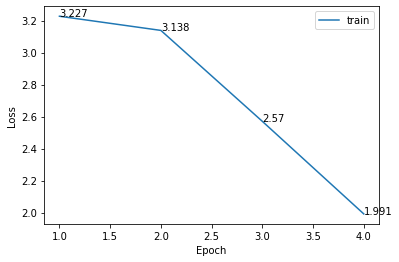

In [ ]:
print("Training Loss")
print_loss(1, params['epochs'])

In [ ]:
def calc_results(start_epoch, end_epoch):
  train_mean_stats = []
  test_mean_stats = []
  print("Processing")
  for cur_epoch in range(start_epoch, end_epoch+1):
    print("Epoch",cur_epoch)
    ckpt.restore(os.path.join(get_weights_path_folder(params),"epoch_"+str(cur_epoch),"ckpt-"+str(cur_epoch)))
    train_pred = model.predict(train_tokens)
    test_pred = model.predict(test_tokens)
    stats = post_process(train_data, train_data_processed, train_tokens, train_pred, None)
    train_mean_stats.append(stats)
    stats = post_process(test_data, test_data_processed, test_tokens, test_pred, None)
    test_mean_stats.append(stats)
  print()
  return train_mean_stats, test_mean_stats

In [ ]:
def print_results(train_mean_f1, test_mean_f1, save_results):
  print("Mean F1")
  print('Train set peak val :',np.max(train_mean_f1, keepdims=True))
  print('Test set peak val :',np.max(test_mean_f1, keepdims=True),'at epoch',1+np.argmax(test_mean_f1))
  print()
  num_epochs = len(train_mean_f1)
  epoch_list = range(1,num_epochs+1)
  plt.plot(epoch_list,train_mean_f1, label = "train")
  plt.plot(epoch_list, test_mean_f1, label = "test")
  for x,y in zip(epoch_list, train_mean_f1):
    label = "{:.4}".format(y)
    plt.annotate(label, (x,y), xytext = (0,7), textcoords = "offset pixels")
  for x,y in zip(epoch_list, test_mean_f1):
    label = "{:.4}".format(y)
    plt.annotate(label, (x,y), xytext = (0,-7), textcoords = "offset pixels")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Mean F1 score")
  if save_results:
    dir = get_weights_path_folder(params)
    plt.savefig(os.path.join(dir, "f1_scores"))

Processing
Epoch 1
Epoch 2
Epoch 3
Epoch 4

Train dataset stats(f1, precision, recall) across epochs
Epoch 1 (0.6302904297969116, 0.7223482166325131, 0.6476026074301762)
Epoch 2 (0.6602521336820317, 0.7476059669059733, 0.6812721087860447)
Epoch 3 (0.6736320234284775, 0.7656307751274999, 0.6849484532855113)
Epoch 4 (0.7166342539325925, 0.7666661816576741, 0.7487342452563002)

Test dataset stats(f1, precision, recall) across epochs
Epoch 1 (0.6429706374064282, 0.6380696936222926, 0.7087168887815437)
Epoch 2 (0.6538242859987151, 0.6446857922842184, 0.7254272656169097)
Epoch 3 (0.6565702893601256, 0.6511685747048372, 0.7202650179259718)
Epoch 4 (0.636975629500323, 0.6250119591435316, 0.7310149305484045)

Mean F1
Train set peak val : [0.71663425]
Test set peak val : [0.65657029] at epoch 3



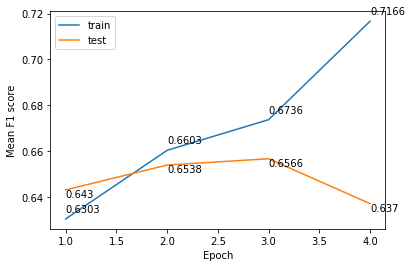

In [ ]:
train_mean_stats, test_mean_stats = calc_results(1, params['epochs'])
print("Train dataset stats(f1, precision, recall) across epochs")
e = 1
for stats in train_mean_stats:
  print("Epoch", e, end=" ")
  print(stats)
  e += 1
print()
print("Test dataset stats(f1, precision, recall) across epochs")
e = 1
for stats in test_mean_stats:
  print("Epoch", e, end=" ")
  print(stats)
  e += 1
print()
train_mean_f1 = [stats[0] for stats in train_mean_stats]
test_mean_f1 = [stats[0] for stats in test_mean_stats]
print_results(train_mean_f1, test_mean_f1 , True)

### Prepare silver data

#### Prestore the civil comments train dataset on drive ( run once )

In [ ]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

 99% 273M/276M [00:02<00:00, 84.0MB/s]
100% 276M/276M [00:02<00:00, 116MB/s] 
 57% 9.00M/15.9M [00:00<00:00, 81.5MB/s]
100% 15.9M/15.9M [00:00<00:00, 101MB/s] 
 98% 12.0M/12.3M [00:00<00:00, 123MB/s]
100% 12.3M/12.3M [00:00<00:00, 113MB/s]
 93% 60.0M/64.7M [00:00<00:00, 104MB/s] 
100% 64.7M/64.7M [00:00<00:00, 120MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 221MB/s]
 32% 5.00M/15.8M [00:00<00:00, 46.8MB/s]
100% 15.8M/15.8M [00:00<00:00, 77.1MB/s]
 41% 5.00M/12.1M [00:00<00:00, 46.2MB/s]
100% 12.1M/12.1M [00:00<00:00, 77.6MB/s]
 94% 306M/326M [00:02<00:00, 116MB/s]
100% 326M/326M [00:02<00:00, 118MB/s]


In [ ]:
!unzip train.csv.zip train.csv

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip test_private_expanded.csv.zip test_private_expanded.csv

Archive:  test_private_expanded.csv.zip
  inflating: test_private_expanded.csv  


In [ ]:
civil_comments = pd.read_csv("train.csv").loc[:,['comment_text','target']]

In [ ]:
civil_comments

,comment_text,target
0,"This is so cool. It's like, 'would you want yo...",0.000000
1,Thank you!! This would make my life a lot less...,0.000000
2,This is such an urgent design problem; kudos t...,0.000000
3,Is this something I'll be able to install on m...,0.000000
4,haha you guys are a bunch of losers.,0.893617
...,...,...
1804869,"Maybe the tax on ""things"" would be collected w...",0.000000
1804870,What do you call people who STILL think the di...,0.000000
1804871,"thank you ,,,right or wrong,,, i am following ...",0.000000
1804872,Anyone who is quoted as having the following e...,0.621212


In [ ]:
civil_comments.to_csv(os.path.join(data_path, "civil_comments_train_dataset.csv"), index = False)

#### Load csv and separate out the most toxic samples as silver data ( run once )

In [ ]:
import pandas as pd

In [ ]:
civil_comments = pd.read_csv(os.path.join(data_path, "civil_comments_train_dataset.csv"))
civil_comments

,comment_text,target
0,"This is so cool. It's like, 'would you want yo...",0.000000
1,Thank you!! This would make my life a lot less...,0.000000
2,This is such an urgent design problem; kudos t...,0.000000
3,Is this something I'll be able to install on m...,0.000000
4,haha you guys are a bunch of losers.,0.893617
...,...,...
1804869,"Maybe the tax on ""things"" would be collected w...",0.000000
1804870,What do you call people who STILL think the di...,0.000000
1804871,"thank you ,,,right or wrong,,, i am following ...",0.000000
1804872,Anyone who is quoted as having the following e...,0.621212


In [ ]:
civil_comments.sort_values('target',0, False, True, ignore_index=True )

In [ ]:
civil_comments

,comment_text,target
0,It's a shame that it's going to be years befor...,1.0
1,And watch the liberal hypocrisy fly.,1.0
2,The FBI has concluded that Hillary Clinton was...,1.0
3,I'll pay $500 for someone to go out there and ...,1.0
4,Dogs should not be used tp apprehend suspects ...,1.0
...,...,...
1804869,The Eugene people enjoy spending their tax dol...,0.0
1804870,"No, tanks.\n\nLet's just start piling up our e...",0.0
1804871,A weak analogy Basic rule.... Canada is not Ch...,0.0
1804872,Amazingly sometimes they don't cave. I put a ...,0.0


In [ ]:
civil_comments = civil_comments.loc[civil_comments['target'] >= 0.80,:]
silver_data = civil_comments.sample(frac=1, random_state=2021).reset_index(drop=True)

In [ ]:
silver_data

,comment_text,target
0,So I have 2 down votes. Next time you don't fe...,0.800000
1,Trudeau looks smarter and smarter for cutting ...,0.833333
2,More divisive bs from the Liberals. Disgusting.,0.847826
3,"I think the Orcas are saying among themselves,...",0.800000
4,You are one dumb guy. Behind all of your fancy...,0.875000
...,...,...
30826,You're just so goll darn funny. Do you stay u...,1.000000
30827,:P Still not enough illegal votes for horrible...,0.833333
30828,stupid killing stupid should remind people tha...,0.921875
30829,"Nope. Trump seems as deranged as ever, sorry. ...",0.800000


In [ ]:
silver_data = silver_data.rename({'comment_text':'text'}, axis = 1)

In [ ]:
silver_data.to_csv(os.path.join(data_path, "civil_comments_toxic_only.csv"), index=False)

#### Preprocess silver dataframe

In [ ]:
import pandas as pd

In [ ]:
silver_data = pd.read_csv(os.path.join(data_path, "civil_comments_toxic_only.csv" )).loc[:, ['text']].reset_index(drop=True)
silver_data['spans'] = [[] for _ in range(silver_data.shape[0])]
silver_data

In [ ]:
silver_data_processed, silver_tokens, silver_input = preprocessing(silver_data, max_length)

(34614, 4)


#### Load model and predict spans

In [ ]:
best_epoch = 3
ckpt.restore(os.path.join(get_weights_path_folder(params),"epoch_"+str(best_epoch),"ckpt-"+str(best_epoch)))

In [ ]:
silver_prediction = model.predict(silver_tokens)
_ = post_process( silver_data , silver_data_processed, silver_tokens, silver_prediction, None )

In [ ]:
silver_data_output = silver_data.drop('spans',axis=1)
silver_data_output = silver_data_output.rename({'predicted_spans':'spans'},axis=1)
silver_data_output = silver_data_output.loc[:,['text','spans']]
silver_data_output

In [ ]:
silver_data_output.to_csv(os.path.join(data_path, "silver_data_annotated_1.csv"), index=False)